In [1]:
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from plots import knn_classifier_plot
from matplotlib.colors import ListedColormap
import seaborn as sns
from plots import plot_classifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

### Linear Regression

In [3]:
class LinearRegression:
    """Linear regression model.
    
    Linear Algebra implementation"""
    
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train):
        """fit regression model and find best coefficients
        
        Parameters
        ----------
        X_train : input values for train
            (n_samples, n_features)
        
        y_train: output values for train
            (n_samples)
        
        Returns
        -------
        class itself
        """
        # y = X.c + e
        # c = [c0, c1, ...]
        # X = [[1, x1, ...]]
        X = self._add_intercept(X_train)
        X_T = X.T
        y = y_train.copy()
        
        # best coeffs(c) = (X^T.X)^-1.X^T.y
        self.c_ = np.linalg.inv(np.dot(X_T, X)).dot(X_T).dot(y)
        self.intercept_ = self.c_[0:1]
        self.coef_ = self.c_[1:]
        
        return self
    
    def predict(self, X_test):
        """predicts test samples
        
        Parameters
        ----------
        X_test : dataset for predictions
            (n_samples, n_features)
        
        Returns
        -------
        y: output values as a numpy array"""
        X = self._add_intercept(X_test)
        
        return np.dot(X, self.c_)
    
    def _predict(self, sample):
        """predicts for one sample"""
        return np.concatenate((np.ones((1)), sample), axis=1).dot(self.c_)
    
    def _add_intercept(self, X):
        """adds intercept of 1 to dataset"""
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    def score(self, X_test, y_test):
        """Calculate R^2 score
        R^2 = 1 - u/v
        u is the regression sum of squares
            ((y_test - y_pred) ** 2).sum()
        v is the residual sum of squares
            ((y_test - y_test.mean()) ** 2).sum()"""
        y_pred = self.predict(X_test)
        u = ((y_test - y_pred) ** 2).sum()
        v = ((y_test - y_test.mean()) ** 2).sum()
        
        return 1 - u/v

In [4]:
class LinearRegressionIterative:
    """Linear Regression Model
    Iterative model using Gradient Descent"""
    
    def __init__(self, learning_rate=0.001, max_iter=100, tol=0.0001):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
    
    def fit(self, X_train, y_train):
        """Fits the data
        
        Parameters
        ----------
        X_train: Feature Dataset
            (n_samples, n_features)
        y_train: Outputs
            (n_samples)"""
        X = X_train.copy()
        y = y_train.copy()
        self.coef_ = np.random.rand(X.shape[1])
        self.intercept_ = np.random.rand(1)
        
        self.costs = []
        prev_cost = float("inf")
        
        for epoch in range(self.max_iter):
            # predict output
            preds = self.predict(X)
            
            # update weights
            d_coef, d_intercept = self.calculate_cost_gradients(y, preds)
            self.coef_ -= self.learning_rate * d_coef
            self.intercept_ -= self.learning_rate * d_intercept
            
            # calculate cost
            cost = self.calculate_cost(y, preds)
            
            if abs(prev_cost - cost) < prev_cost * self.tol:
                break
            
            self.costs.append(cost)
            prev_cost = cost
        
        return self
    
    def calculate_cost(self, y, preds):
        """calculates cost
        cost: sum((labels - predictions) ^ 2)"""
        return ((y - preds) ** 2).mean()
    
    def calculate_cost_gradients(self, y, preds):
        """calculates cost gradients
        d_weights: 2 * (labels - predictions) * -w
        d_bias: 2 * (labels - predictions) * -1"""
        coef_gradient = (2 * (y - preds).reshape(-1, 1) * -self.coef_).mean(axis=0)
        intercept_gradient = np.array([(2 * (y - preds) * -1).mean()])
        
        return coef_gradient, intercept_gradient
    
    def predict(self, X):
        """Predicts output of given dataset
        predictions: X * weights + bias"""
        preds = np.dot(X, self.coef_) + self.intercept_
        return preds.ravel()
    
    def score(self, X_test, y_test):
        """R^2 score: 1 - u/v"""
        preds = self.predict(X_test)
        u = ((y_test - preds) ** 2).sum() / len(y_test)
        v = ((y_test - y_test.mean()) ** 2).sum() / len(y_test)
        return 1 - u / v

In [5]:
class LinearRegressionIterative2:
    """Linear Regression Model
    Iterative model using Gradient Descent"""
    
    def __init__(self, learning_rate=0.001, max_iter=100, tol=0.00001):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self, X_train, y_train):
        """fits the model using training data
        
        Parameters
        ----------
        X_train: Feature Dataset
            (n_samples, n_features)
        y_train: Outputs
            (n_samples)"""
        X = X_train.copy()
        X = self._add_intercept(X)
        y = y_train.copy()
        
        self.w_ = np.random.rand(X.shape[1])
        
        prev_cost = np.float("inf")
        self.costs = []
        
        for epoch in range(self.max_iter):
            # update weights
            preds = self.predict(X, fit_intercept=False)
            cost_gradient = self.calculate_cost_gradient(X, y, preds)
            self.w_ -= self.learning_rate * cost_gradient
            
            # calculate and check cost
            cost = self.calculate_cost(y, preds)
            
            if abs(prev_cost - cost) < prev_cost * self.tol:
                break
            
            self.costs.append(cost)
            prev_cost = cost
        
        return self
    
    def predict(self, X, fit_intercept=True):
        """predicts the output for X
        
        preds = X*w"""
        if fit_intercept:
            X = self._add_intercept(X)
        return np.dot(X, self.w_).ravel()
    
    def calculate_cost(self, y, preds):
        """calculates cost
        cost = mean((y - predictions)^2)"""
        cost = ((y - preds) ** 2).mean()
        return cost
    
    def calculate_cost_gradient(self, X, y, preds):
        """calculates cost gradient
        
        gradient = -2 * X.T * (y - preds) / (n_features + 1)"""
        return (-2 * np.dot(X.T, (y - preds))) / X.shape[1]
    
    def _add_intercept(self, X):
        """adds column vector of ones(1) to beginning of X"""
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    def score(self, X, y):
        """R^2 score -> 1 - u/v"""
        preds = self.predict(X)
        u = ((y - preds) ** 2).mean()
        v = ((y - y.mean()) ** 2).mean()
        return 1 - u / v

### Ridge Regression

In [6]:
class RidgeRegression:
    """Ridge regression model."""
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def fit(self, X_train, y_train):
        """fit regression model and find best coefficients
        
        Parameters
        ----------
        X_train : input values for train
            (n_samples, n_features)
        
        y_train: output values for train
            (n_samples)
        
        Returns
        -------
        class itself
        """
        # y = X.c + e
        # c = [c0, c1, ...]
        # X = [[1, x1, ...]]
        X = self._add_intercept(X_train)
        X_T = X.T
        I = np.eye(X_T.shape[0])
        y = y_train.copy()
        
        # best coeffs(c) = (X^T.X + alpha.I)^-1.X^T.y
        self.c_ = np.linalg.inv(np.dot(X_T, X) + self.alpha*I).dot(X_T).dot(y)
        self.intercept_ = self.c_[0:1]
        self.coef_ = self.c_[1:]
        
        return self
    
    def predict(self, X_test):
        """predicts test samples
        
        Parameters
        ----------
        X_test : dataset for predictions
            (n_samples, n_features)
        
        Returns
        -------
        y: output values as a numpy array"""
        X = self._add_intercept(X_test)
        
        return np.dot(X, self.c_)
    
    def _predict(self, sample):
        """predicts for one sample"""
        return np.concatenate((np.ones((1)), sample), axis=1).dot(self.c_)
    
    def _add_intercept(self, X):
        """adds intercept of 1 to dataset"""
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    def score(self, X_test, y_test):
        """Calculate R^2 score
        R^2 = 1 - u/v
        u is the regression sum of squares
            ((y_test - y_pred) ** 2).sum()
        v is the residual sum of squares
            ((y_test - y_test.mean()) ** 2).sum()"""
        y_pred = self.predict(X_test)
        u = ((y_test - y_pred) ** 2).sum()
        v = ((y_test - y_test.mean()) ** 2).sum()
        
        return 1 - u/v

### Logistic Regression

In [7]:
class LogisticRegression:
    """Logistic Regression Classifier"""
    
    def __init__(self, max_iter=1000, learning_rate=0.01, threshold=0.5, tol=0.0001):
        """
        Parameters
        ----------
        max_iter: max iteration number
        learning_rate: learning rate of model
        threshold: threshold between two class predictions"""
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.tol = tol
        
    def fit(self, X_train, y_train):
        """Fits data and find weights
        
        Parameters
        ----------
        X_train : input values for train
            (n_samples, n_features)
        y_train: output values for train
            (n_samples)
        
        Returns
        -------
        class itself
        """
        X = self._add_intercept(X_train)
        y = y_train.copy()
        self.w_ = np.zeros(X.shape[1])
        
        prev_cost = float("inf")
        self.costs = []
        
        for epoch in range(self.max_iter):
            # update weights
            gradient = self.calculate_cost_gradient(X, y)
            self.w_ -= self.learning_rate * gradient
            
            # calculate cost
            cost = self.calculate_cost(X, y)
            
            if abs(prev_cost - cost) < self.tol * prev_cost:
                break
            
            prev_cost = cost
            self.costs.append(cost)
        
        self.intercept_ = self.w_[0:1]
        self.coef_ = self.w_[1:]
        
        return self
    
    def predict_proba(self, X, fit_intercept=True):
        """predict probabilities"""
        if fit_intercept:
            X = self._add_intercept(X)
        z = np.dot(X, self.w_)
        return self.sigmoid(z)

    def predict(self, X, fit_intercept=True):
        """predicts classes"""
        # get probabilities and use threshold
        probas = self.predict_proba(X, fit_intercept)
        preds = np.where(probas >= self.threshold, 1, 0)
        
        return preds
    
    def _add_intercept(self, X):
        """adds intercept of 1 to dataset"""
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    def sigmoid(self, z):
        """calculates sigmoid of value(s)
        1 / (1 + e^-z)"""
        return 1.0 / (1 + np.exp(-z))
    
    def calculate_cost(self, X, y):
        """calculates cost function
        
        Parameters
        ----------
        X: features dataset
            (n_samples, n_features+1)
        y: true labels of features dataset
            (n_samples)"""
        # y_hat = prediction probability = sigmoid(X*w)
        # if y == 1 -> cost = - log(y_hat)
        # if y == 0 -> cost = - log(1 - y_hat)
        #
        # In 1 equation:
        # cost = -y * log(y_hat) - (1 - y) * log(1 - y_hat)
        y_hat = self.predict_proba(X, fit_intercept=False)
        
        cost = (-y * np.log(y_hat) - (1-y) * np.log(1-y_hat)).mean()
        
        return cost
    
    def calculate_cost_gradient(self, X, y):
        """calculates gradient of cost function
        
        Parameters
        ----------
        X: features dataset
            (n_samples, n_features+1)
        y: true labels of features dataset
            (n_samples)
        
        Returns
        -------
        gradient: gradient vector
            (n_features+1)"""
        # cost gradient = X^T * (preds - y)
        y_hat = self.predict_proba(X, fit_intercept=False)
        
        gradient = np.dot(X.T, y_hat - y) / X.shape[1]
        
        return gradient
    
    def score(self, X_test, y_test):
        """calculates accuracy score"""
        preds = self.predict(X_test)
        score = (preds == y_test).mean()
        
        return score

In [71]:
# simple logistic regression
class LogisticRegressionSimple:
    
    def __init__(self, max_iter=1000, l_rate=0.001, threshold=0.5, tol=0.000001):
        self.max_iter = max_iter
        self.l_rate = l_rate
        self.threshold = threshold
        self.tol = tol
    
    def fit(self, X, y):
        self.w = np.random.rand(X.shape[1])
        self.b = np.random.rand((1))[0]
        
        self.costs = []
        prev_cost = float("inf")
        
        # learning
        for i in range(self.max_iter):
            # probabilities
            y_hat = self.sigmoid(np.dot(X, self.w) + self.b)
            
            # gradients
            d_w = np.dot(X.T, y_hat - y) / len(self.w)
            d_b = (y_hat - y).sum() / len(self.w)
            
            # gradient descent
            self.w -= self.l_rate * d_w
            self.b -= self.l_rate * d_b
            
            # cost check
            cost = (- y * np.log(y_hat) - (1-y) * np.log(1 - y_hat)).mean()
            
            if (prev_cost - cost) < prev_cost * self.tol:
                break
            
            self.costs.append(cost)
            prev_cost = cost
        
        return self
        
    def predict(self, X):
        y_hat = self.sigmoid(np.dot(X, self.w) + self.b)
        return np.where(y_hat > self.threshold, 1, 0)
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def score(self, X, y):
        preds = self.predict(X)
        return (preds == y).mean()

### Dataset

In [9]:
cars = pd.read_csv("datasets/cars_updated.csv")

In [10]:
hp_t = cars[["hp", "torque"]].drop_duplicates()

X = hp_t.hp.values
y = hp_t.torque.values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [12]:
scaler = MinMaxScaler()

In [13]:
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.reshape(-1, 1))

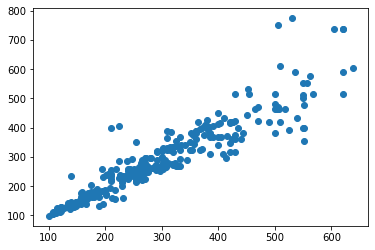

In [14]:
plt.figure()
plt.scatter(X_train, y_train)

### Linear Regression hp torque

In [15]:
lin_reg = LinearRegression().fit(X_train.reshape(-1, 1), y_train)

In [16]:
lin_reg.c_

array([7.17578124, 0.95166697])

Text(0, 0.5, 'Torque')

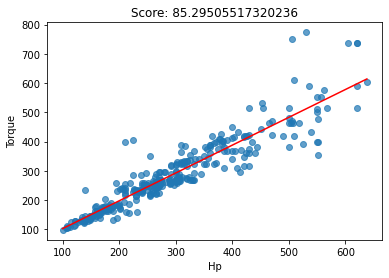

In [17]:
plt.figure()

interval = np.array([X_train.min(), X_train.max()])
preds = lin_reg.predict(interval.reshape(-1, 1))
r_score = lin_reg.score(X_test.reshape(-1, 1), y_test)
plt.title("Score: {}".format(r_score * 100))
plt.scatter(X_train, y_train, alpha=0.7)
plt.plot(interval, preds, color="red")
plt.xlabel("Hp")
plt.ylabel("Torque")

### Linear Regression Gradient Descent

In [18]:
lin_reg = LinearRegressionIterative(learning_rate=0.001, max_iter=100, tol=0.0001).fit(X_train.reshape(-1, 1), y_train)

Text(0, 0.5, 'Torque')

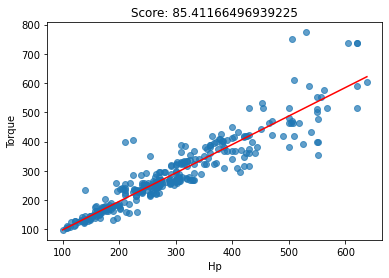

In [19]:
plt.figure()

interval = np.array([X_train.min(), X_train.max()])
preds = lin_reg.predict(interval.reshape(-1, 1))
r_score = lin_reg.score(X_test.reshape(-1, 1), y_test)
plt.title("Score: {}".format(r_score * 100))
plt.scatter(X_train, y_train, alpha=0.7)
plt.plot(interval, preds, color="red")
plt.xlabel("Hp")
plt.ylabel("Torque")

### Linear Regression Gradient Descent 2 (More Convenient)

In [20]:
lin_reg = LinearRegressionIterative2(learning_rate=0.001, max_iter=1000, tol=0.00001).fit(X_train_scaled.reshape(-1, 1), y_train)

Text(0, 0.5, 'Torque')

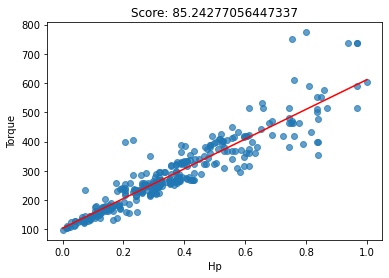

In [21]:
plt.figure()

interval = np.array([X_train_scaled.min(), X_train_scaled.max()])
preds = lin_reg.predict(interval.reshape(-1, 1))
r_score = lin_reg.score(X_test_scaled.reshape(-1, 1), y_test)
plt.title("Score: {}".format(r_score * 100))
plt.scatter(X_train_scaled, y_train, alpha=0.7)
plt.plot(interval, preds, color="red")
plt.xlabel("Hp")
plt.ylabel("Torque")

### Ridge Regression

In [22]:
rid_reg = RidgeRegression(alpha=1).fit(X_train.reshape(-1, 1), y_train)

In [23]:
rid_reg.score(X_test.reshape(-1, 1), y_test)

0.8529715589268656

In [24]:
for alpha in [0.01, 0.1, 1, 10, 100, 1000]:
    rid_reg = RidgeRegression(alpha=alpha).fit(X_train.reshape(-1, 1), y_train)
    score = rid_reg.score(X_test.reshape(-1, 1), y_test)
    print("alpha: {}, score: {}".format(alpha, score))

alpha: 0.01, score: 0.8529507684759471
alpha: 0.1, score: 0.8529527129508347
alpha: 1, score: 0.8529715589268656
alpha: 10, score: 0.8531135607660059
alpha: 100, score: 0.8534068483203813
alpha: 1000, score: 0.8534515224118343


### logistic regression

In [80]:
# synthetic classification
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                          class_sep=2,flip_y=0,weights=[0.5,0.5], random_state=24)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [82]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

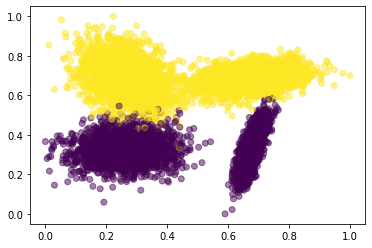

In [83]:
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, alpha=0.5)

In [93]:
log_reg = LogisticRegressionSimple(tol=0.0001).fit(X_train_scaled, y_train)

In [94]:
log_reg.score(X_test_scaled, y_test)

0.9912

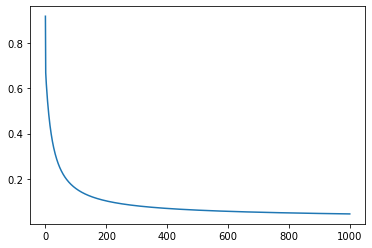

In [95]:
plt.figure()
plt.plot(range(len(log_reg.costs)), log_reg.costs)

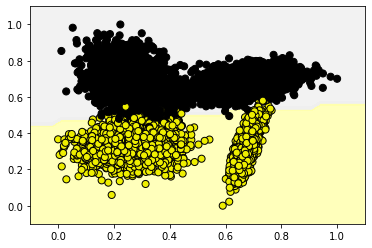

In [96]:
plot_classifier(log_reg, X_train_scaled, y_train)

In [37]:
log_reg.coef_

array([-5.77612799, 44.48681353])

In [38]:
log_reg.intercept_

array([-19.93289064])